# Piezo-electro sensor

- Nicolò Montalti (S4947231)
- ...

In [2]:
import numpy as np                          # used for array manipulation
from scipy.integrate import solve_ivp, odeint       # used to solve differential equation
from scipy.signal import find_peaks         # used to analyze the result
from scipy import fft                       # fourier transform
from matplotlib import pyplot as plt, cm    # plotting
from ipywidgets import widgets              # interactive widgets

# display plots in the notebook
%matplotlib inline

## Differential equation
We know that the ideal spring euqation $F = kx$ can be improved adding a non-linear component $\alpha kx^3$. So for the static case, without friction we have
$$
 F = kx + \alpha k^3x^3 
$$
Adding friction, proportional to $\dot{x}$ with a coefficient $\lambda$, and inertia we have
$$
    F = kx + \alpha k^3x^3 + \lambda \dot{x} + m \ddot{x}
$$
Since $q = Kx$
$$
F = \frac{k}{K} q + \alpha\frac{k^3}{K^3}q^3 + \frac{\lambda}{K}\dot{q} + \frac{m}{K}\ddot{q} = \frac{m}{K} \left( \frac{k}{m} q + \alpha\frac{k}{m}\frac{k^2}{K^2}q^3 + \frac{\lambda}{m}\dot{q} + \ddot{q} \right)
$$
Using $\omega_0 = \sqrt{k/m}$, $\xi = \lambda/2\sqrt{km}$ and $d = K / k $ we get
$$
F = \frac{1}{d \omega_0^2}\left[ \ddot{q} + 2\xi\omega_0\dot{q} + \omega_0^2 \left(1 + \alpha \frac{q^2}{d^2} \right) q \right]
$$
which, in the linear case ($\alpha = 0$), reads
$$
F = \frac{1}{d \omega_0^2}\left[ \ddot{q} + 2\xi\omega_0\dot{q} + \omega_0^2 q \right]
$$

## Solving the differential equation
We can know define the functions necessary to solve the differential equation

In [128]:
def force(t, omega):
    '''
    This function computes the force with which the piezo-electro sensor is stimulated.
    It is a harmonic force of amplitude 1 and angular frequency omega.

    Parameters:
    -----------
    t: time [s]
    omega: angular frequency [s^-1]

    Returns:
    --------
    (float) sin(omega*t)
    '''
    return np.sin(omega*t)

def q_vector_derivative(t, q_vector, omega, omega_0, xi, d, alpha):
    '''
    This function 

    Parameters:
    -----------
    t: time [s]
    q_vector: numpy array of the form (q,q'), where q is the charge [C]
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]

    Returns:
    --------
    (numpy array) derivative of [q,q']
    '''

    q0 = q_vector[0]                                                                                                            # q(t)
    q1 = q_vector[1]                                                                                                            # q'(t)
    q0_d = q1                                                                                                                   # q(t+dt)' = q'(t)
    q1_d = d * omega_0**2 * force(t, omega) - 2 * xi * omega_0 * q1 - omega_0**2 * (1 + alpha * q0**2 / d**2) * q0              # q(t+dt)'' according to the differential equation

    return np.array([q0_d, q1_d])

def solve_differential_equation(periods, initial_condition, omega, omega_0=1, xi=1, d=1, alpha=0):
    '''
    Solve the differential equation q_vector(t)' = q_vector_derivative(t, omega, omega_0, xi, d, alpha)
    
    Parameters:
    ------------
    time_points: array-like sequence of time instants where to solve the equation
    inital_condition: array with the inistal condition [q_init, q_init']
    omega: angular frequency of force [s^-1]
    omega_0: natural frequency of the system [s^-1]
    xi: damping factor of the system [dimensionless]
    d: charge sensitivity parameter [C/N]
    alpha: non-linear factor [N^-2]

    Returns:
    --------
    (time_points, q_vector_solution)
    '''

    total_time = periods * 2 * np.pi / omega_0                                                                                  # time where to compute the solution
    time_points = np.linspace(0, total_time, 100*periods)                                                                       # time is split in 100 points per period

    jacobian = lambda t, q_vect, omega=omega, omega_0=omega_0, alpha=alpha, d=d, xi=xi :  np.array([[0, 1],
                                                                                                   [omega_0**2 + 3 * alpha * q_vect[0]**2 / d**2, -2*xi*omega_0]])

    ode_solution = solve_ivp(q_vector_derivative, (0, total_time),
                             initial_condition, t_eval=time_points,
                             args=(omega, omega_0, xi, d, alpha),
                             method='LSODA', jac=jacobian)                                                                       # LSODA method from odeint  
                            
    return (ode_solution.t, ode_solution.y)

## Validation
If we set $\xi =\alpha = \omega = 0$ and $d = 1$, since $\sin(0) = 0$, the differentail equation becomes
$$
\ddot{q}+\omega_0^2 q = 0
$$
which is the equation of an harmonic oscillator. We know that for the initial conditions ($q=1, \dot{q}=0$) the solution is $\cos(\omega_0 t)$. The velocity should be out of phase by $\pi/2\omega_0$.

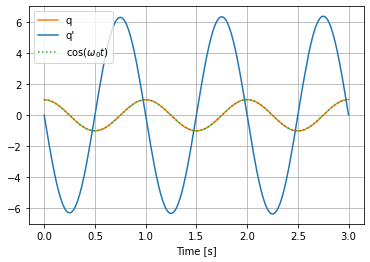

In [129]:
def plot_validation():
    '''
    This function plots q, q' and cos(omega_0*t) with omega = xi = alpha = 0, d = 1 and initial condition [1,0].
    '''
    omega_0 = 2*np.pi
    t, y = solve_differential_equation(3, np.array([1, 0]), omega=0, omega_0=omega_0, xi=0, d=1, alpha=0)

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(t,y[0], label='q', color='tab:orange')
    ax.plot(t, y[1], label='q\'', color='tab:blue')
    ax.plot(t, np.cos(omega_0*t), linestyle=':', label=r'$\cos(\omega_0 t)$', color='tab:green')
    ax.legend()
    ax.grid()
    ax.set_xlabel('Time [s]')

plot_validation()

Adding the damping factor, we expect the oscillator to be underdamped for $\xi < 1$, critically damped for $\xi = 1$ and overdamped for $\xi > 1$. For $\xi >> 1$ we expect q not to change. The underdamped solution should decrease as $e^{-\xi \omega_0 t}$.

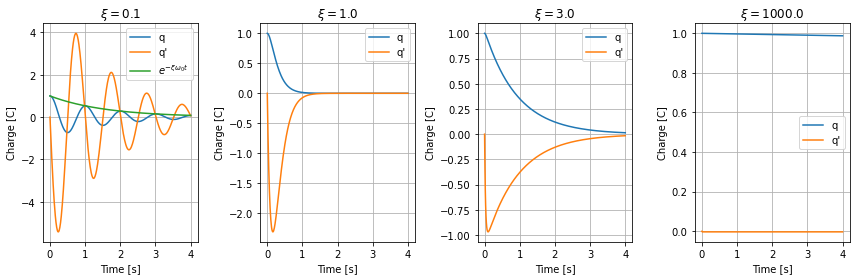

In [130]:
def plot_validation_damping():
    '''
    This function generates three plots of q over t. The first one with xi = 0.1 (underdamped), the second with xi = 1 (critically damped) and the third one with xi = 3 (overdamped).
    '''
    xis = np.array([0.1, 1, 3, 1000])
    omega_0 = 2*np.pi
    fig = plt.figure(figsize=(12,4))
    axs = fig.subplots(1,xis.size)

    for xi, ax in zip(xis, axs):
        t, y = solve_differential_equation(4, np.array([1, 0]), omega=0, omega_0=omega_0, xi=xi, d=1, alpha=0)
        ax.plot(t, y[0], label='q')
        ax.plot(t, y[1], label='q\'')
        if ax == axs[0]:
            ax.plot(t, np.exp(-0.1*omega_0*t), label=r'$e^{-\xi \omega_0 t}$')

        ax.grid()
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Charge [C]')
        ax.set_title(r'$\xi = ${}'.format(xi))
        ax.legend()
    

    fig.tight_layout()

plot_validation_damping()

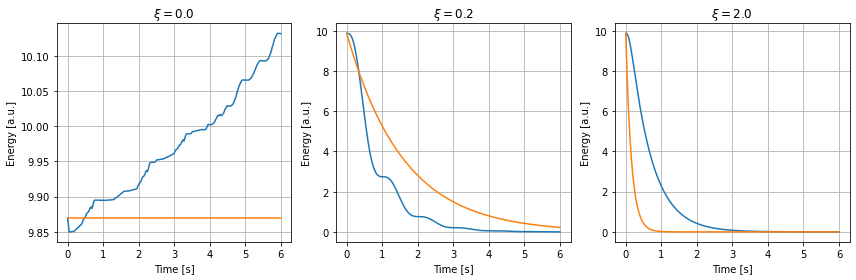

In [131]:
def plot_validation_energy():
    xis = np.array([0, 0.2, 2])
    omega_0 = np.pi

    fig = plt.figure(figsize=(12,4))
    axs = fig.subplots(1,3)

    for xi, ax in zip(xis, axs):
        t, y = solve_differential_equation(3, np.array([1., 0]), omega=0, omega_0=omega_0, xi=xi, d=1, alpha=0)
        ax.plot(t, omega_0**2 * y[0]**2 + y[1]**2, label='numerical solution')
        ax.grid()
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Energy [a.u.]')
        ax.set_title(r'$\xi = ${}'.format(xi))
        ax.plot(t, omega_0**2 * np.exp(-omega_0*xi*t))

    fig.tight_layout()

plot_validation_energy()

## Linear case
We first investigate the linear case ($\alpha = 0$). In particular we are interested in the dependence of the solution on $\omega$ and $\xi$

In [124]:
def plot_time_dependence(omega, xi, periods):
    '''
    Makes three plots given the values of omega and xi:
        - the first plot shows the dependance of charge on time over a 20 periods;
        - the second one is a phase diagram;
        - the third one shows the fourier transform of the first plot, plus the value of omega.    
    '''
    initial_condition = np.array([0,0])
    omega_0 = 1

    t, y = solve_differential_equation(periods, initial_condition, omega=omega, omega_0 = omega_0, xi=xi)
    
    fig = plt.figure(figsize=(16,4))
    axs = fig.subplots(1,3)
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Charge [C]')
    axs[0].plot(t, y[0])
    axs[0].grid(True)
    axs[0].set_title('Time evolutionover {} periods'.format(periods))
    #axs[0].set_ylim(-1.5, 1.5)

    axs[1].plot(y[0], y[1])
    axs[1].grid(True)
    axs[1].set_title('Phase space')
    axs[1].set_xlabel(r'$q$ [C]')
    axs[1].set_ylabel(r'$\dot{q}$ [C/s]')

    N = t.size
    delta_t = t[1]-t[0]
    signal_fft = fft.fft(y[0])
    frequencies = fft.fftfreq(N, delta_t)
    axs[2].set_xlim(0, 2*np.pi)
    axs[2].plot(frequencies[:N//2]*2*np.pi, np.abs(signal_fft[: N//2]), label='FFT (charge)')
    axs[2].axvline(omega_0, color='tab:red', label=r'$\omega_0$ (charge)')
    axs[2].axvline(omega, color='tab:orange', label=r'$\omega$ (force)')
    axs[2].grid(True)
    axs[2].set_title('Fourier transform')
    axs[2].set_xlabel(r'$\omega$ [$s^{-1}$]')
    axs[2].set_ylabel('Amplitude (a.u.)')
    axs[2].legend()

    fig.tight_layout()
    

# With the following widgets it's possible to interact with the plots modifying the values of omega, xi and the number of periods.
widget_omega = widgets.FloatSlider(np.pi, min=0.01, max=np.pi*2, description='Omega')
widget_xi = widgets.FloatSlider(1, min=0, max=2, description='Xi')
widget_periods = widgets.IntSlider(10, min=1, max=100, description='Periods')

widgets.interact(plot_time_dependence, omega = widget_omega, xi=widget_xi, periods=widget_periods)

interactive(children=(FloatSlider(value=3.141592653589793, description='Omega', max=6.283185307179586, min=0.0…

<function __main__.plot_time_dependence(omega, xi, periods)>

Varying $\omega$ and $\xi$ in the prevoius plots,we found out...

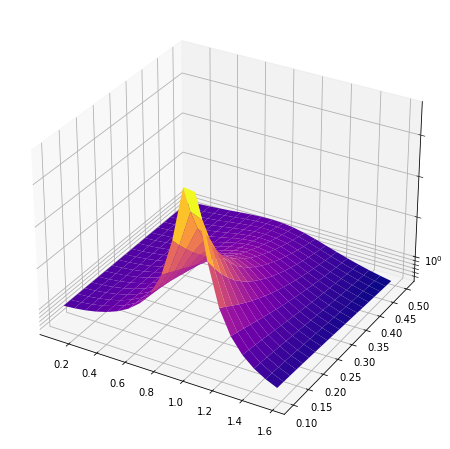

In [27]:
def plot_xi_omega_dependance():
    '''
    Plots the amplitude after 20 periods (stable solution) for different values of xi and omega.
    '''
    N = 20                                                                                      # Number of division of omega and xi range. If N > 30, computation takes too much time: O(N^2)
    omegas = np.linspace(0.1, np.pi/2, N)
    xis = np.linspace(0.1, 0.5, N)

    def solve_for_omega_xi(omega, xi):
        periods = 20
        _, y = solve_differential_equation(periods, np.array([0,0]), omega=omega, xi=xi)
        peaks, _ = find_peaks(y[0])
        return y[0, peaks[-1]]                                                                  # return the last peak (amplitude of the stable solution)

    omegas, xis = np.meshgrid(omegas, xis)                                                      # mixing omegas and xis on all the xy plane
    vect_func = np.vectorize(solve_for_omega_xi)                                                # preparing the function to be computed
    amplitude = vect_func(omegas, xis)                                                          # computing the function all over the plane

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(omegas, xis, amplitude, cmap=cm.plasma)
    ax.set_zscale('log')                                                                        # setting a log scale on z axis to improve plot clarity

plot_xi_omega_dependance()

### Discussion
...

## Non-linear case

In [125]:
def plot_time_dependence(omega, periods, linearity):
    '''
    Makes three plots given the values of omega and xi:
        - the first plot shows the dependance of charge on time over a 20 periods;
        - the second one is a phase diagram;
        - the third one shows the fourier transform of the first plot, plus the value of omega.    
    '''
    if linearity == 'Non linear':
        alpha = 0.5
    else:
        alpha = 0
        
    xi = 0.01
    omega_0 = 1

    initial_condition = np.array([0,0])
    t, y = solve_differential_equation(periods, initial_condition, omega=omega, omega_0=omega_0, xi=xi, alpha=alpha)
    
    fig = plt.figure(figsize=(16,4))
    axs = fig.subplots(1,3)
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Charge [C]')
    axs[0].plot(t, y[0])
    axs[0].grid(True)
    axs[0].set_title('Time evolutionover 20 periods')
    #axs[0].set_ylim(-1.5, 1.5)

    axs[1].plot(y[0], y[1])
    axs[1].grid(True)
    axs[1].set_title('Phase space')
    axs[1].set_xlabel(r'$q$ [C]')
    axs[1].set_ylabel(r'$\dot{q}$ [C/s]')

    N = t.size
    delta_t = t[1]-t[0]
    signal_fft = fft.fft(y[0])
    frequencies = fft.fftfreq(N, delta_t)
    axs[2].set_xlim(0, 2*np.pi)
    axs[2].plot(frequencies[:N//2]*2*np.pi, np.abs(signal_fft[: N//2]), label='FFT (charge)')
    axs[2].axvline(omega, color='tab:orange', label=r'$\omega$ (force)')
    axs[2].axvline(omega_0, color='tab:red', label=r'$\omega_0$ (charge)')
    axs[2].grid(True)
    axs[2].set_title('Fourier transform')
    axs[2].set_xlabel(r'$\omega$ [$s^{-1}$]')
    axs[2].set_ylabel('Amplitude (a.u., log scale)')
    axs[2].set_yscale('log')
    axs[2].legend()

    fig.tight_layout()
    

# With the following widgets it's possible to interact with the plots modifying the values of omega, the number of periods. It is also possible to add non-linearity effects
widget_omega = widgets.FloatSlider(2, min=0.01, max=3, description='Omega')
widget_periods = widgets.IntSlider(50, min=1, max=100, description='Periods')
widget_linearity = widgets.RadioButtons(options=['Linear', 'Non linear'], description='Linearity')


widgets.interact(plot_time_dependence, omega = widget_omega, periods=widget_periods, linearity = widget_linearity)

interactive(children=(FloatSlider(value=2.0, description='Omega', max=3.0, min=0.01), IntSlider(value=50, desc…

<function __main__.plot_time_dependence(omega, periods, linearity)>